In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2
from importlib import reload
import pickle
import PIL

In [8]:
os.chdir('../..')
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis import Sankey_Functions
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [9]:
from scripts.figures import interogate_queries, labels
from scripts.figures  import plotter

# Define lists & file paths

In [10]:
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = r'/Volumes/Encrypted/Semiology-Visualisation-Tool/resources/__Semio2Brain Database v1.1.0.xlsx'

with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [11]:
region_names = labels.get_region_names()

In [12]:
semiology_list = list(recursive_items(SemioDict))

# Get df from Excel sheet & query df

If previously run notebook, get pickled results of MEGA_ANALYSIS, QUERY_SEMIOLOGY, normalisatione etc, and then go straight to Get sorted list of semiologies

In [13]:
with open('scripts/figures/query_results_pickle.pkl', 'rb') as f:
    query_results = pickle.load(f)
    
with open('scripts/figures/all_dfs_pickle.pkl', 'rb') as f:
    all_dfs = pickle.load(f)

If no pickle available, run:

In [112]:
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database)
print(original_df.shape)

(2577, 121)


In [115]:
def query_semiology_wrapper(df, semiology_list, semiology_dict_path):
    query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=semiology_dict_path,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        query_results[semiology] = one_query_result
    return query_results

In [289]:
df = copy.deepcopy(original_df)
all_dfs = {}
all_dfs['raw'] = {
    'full': df,
    'spontaneous': df[df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  df[df['Spontaneous Semiology (SS)'] != 'y'],
}

In [290]:
query_results = {}
query_results['raw'] = {}
for key, df in all_dfs['raw'].items():
    query_results['raw'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [362]:
reload(Sankey_Functions)
top_level_normalised_df = Sankey_Functions.normalise_top_level_localisation_cols_OTHER(copy.deepcopy(original_df))[0]
all_dfs['top_level_normalised'] = {
    'full': top_level_normalised_df,
    'spontaneous': top_level_normalised_df[top_level_normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  top_level_normalised_df[top_level_normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [363]:
query_results['top_level_normalised'] = {}
for key, df in all_dfs['top_level_normalised'].items():
    query_results['top_level_normalised'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [364]:
reload(Sankey_Functions)
temporal_normalised_df = Sankey_Functions.normalise_localisation_cols_OTHER_SplitTL(copy.deepcopy(original_df))[0]
all_dfs['temporal_normalised'] = {
    'full': temporal_normalised_df,
    'spontaneous': temporal_normalised_df[temporal_normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  temporal_normalised_df[temporal_normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [365]:
query_results['temporal_normalised'] = {}
for key, df in all_dfs['temporal_normalised'].items():
    query_results['temporal_normalised'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [440]:
with open('scripts/figures/query_results_pickle.pkl', 'wb') as f:
    pickle.dump(query_results, f)
    
with open('scripts/figures/all_dfs_pickle.pkl', 'wb') as f:
    pickle.dump(all_dfs, f)

# Get sorted list of semiologies

In [ ]:
def sort_semiologies_by_n(query_result, top_n = 0, include_n = False):
    """
    Get semiologies in order of most frequently seen, based on query results
    
    Input:
    - query_results: a dictionary where keys are semiologies and values are
    'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
    (often query_results['not_normalised']['full'])
    - top_n can be used to get the n semiologies with the highest number of cases
    - include_n = True to return the frequency of each semiology
    """
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    
    labels = list(query_result.keys())
    sorted_result = np.sort(n_results)
    sorted_index = np.argsort(n_results)
    sorted_labels = [labels[i] for i in sorted_index]
    if include_n:
        return tuple(zip(sorted_labels[-top_n:], sorted_result[-top_n:]))
    else:
        return sorted_labels[-top_n:]

In [ ]:
sorted_semiologies = sort_semiologies_by_n(query_results['raw']['full'])

# Compare normalisation methods

In [526]:
reload(interogate_queries)

<module 'scripts.figures.interogate_queries' from '/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py'>

In [510]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']+['Localising']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-12:]
processed_dfs = {}
for normalised_type, sub_query_results in query_results.items():
    processed_dfs[normalised_type] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_type][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            bootstrapping_samples=1000,
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

TypeError: summarise_query() got an unexpected keyword argument 'other_regions_included'

In [527]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']

results, localising = interogate_queries.summarise_query(
    query_results['raw']['full'],
    axis = 'semiology',
    region_names = region_names,
    normalise = True,
    merge_temporal = False,
    semiologies_of_interest = sorted_semiologies[-12:],
    drop_other_semiology = True,
    regions_of_interest = regions_of_interest,
    drop_other_regions = False,
    confint_method = 'binomial',
    bootstrapping_samples=100)

In [533]:
pd.concat([results['counts'], results['counts'].sum(1), localising], 1)

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,CING,PL,OL,INSULA,Hypothalamus,All other,0,Localising
Epigastric,217.938354,39.422296,332.486157,0.743817,2.975268,27.763566,4.786822,11.488372,12.445736,80.418605,4.786822,5.744186,741.0,741.0
Psychic,186.861844,15.404381,204.945248,2.009267,0.669756,16.473140,8.721074,7.752066,3.876033,16.473140,0.000000,5.814050,469.0,469.0
Autonomic,194.225069,17.282739,257.595113,2.468963,0.822988,70.576923,6.587179,21.643590,11.292308,113.864103,28.230769,9.410256,734.0,734.0
Olfactory,75.863578,34.741265,151.018151,1.418011,1.418011,105.426230,8.040984,88.450820,12.508197,471.737705,0.000000,30.377049,981.0,981.0
Somatosensory,42.206014,4.545263,58.439096,0.649323,0.649323,67.014641,6.426061,68.850659,3.672035,349.761347,0.000000,24.786237,627.0,627.0
Non-Specific Aura,100.724428,46.699507,226.172124,21.976239,24.723269,60.320197,10.701970,12.647783,8.756158,268.522167,3.891626,4.864532,790.0,790.0
Head Version,176.845390,31.148904,240.148001,3.014410,0.000000,81.150242,5.796446,24.151858,15.457189,0.966074,11.592892,7.728595,598.0,598.0
Tonic,197.214515,21.756761,234.411559,2.807324,2.105493,275.165217,34.747826,53.530435,33.808696,62.921739,19.721739,33.808696,972.0,972.0
Dystonic,199.943848,23.311839,295.881031,0.896609,0.896609,77.735669,8.076433,8.076433,10.095541,1.009554,0.000000,8.076433,634.0,634.0
Automatisms - Oral & Manual,743.752912,131.676099,1030.980447,9.405436,10.128931,205.497728,66.906237,30.585708,37.276332,10.513837,22.939281,14.337051,2314.0,2314.0


In [382]:
def need_counts(query_results, columns_of_interest):
    """
        Converts query results to matrix of counts by semiology and localisation
        
        Inputs
        - query_results: a dictionary where keys are semiologies and values are
        'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
        - Requires region_names, a dictionary of defined groups of localisations
        - *merge_temporal: False if want to break down top level label TL into anterior,
        posterior etc.
        - *other_included: True if want to keep all top level localisation columns. False
        will drop interlobar junctions etc.

        Returns
        - counts_df: a matrix where columns are localisations and index are
        semiologies, where the values are the number of datapoints corresponding to that
        localisation and semiology
    """
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [480]:
all_regions = need_counts(query_results['raw']['full'], region_names['top_level'])
temporal_only = need_counts(query_results['raw']['full'], region_names['low_level_temporal_of_interest'])
localising = need_counts(query_results['raw']['full'], ['Localising'])

In [485]:
top_level_normalised

array([0.95736434, 0.85245902, 0.96900826, 0.94102564, 0.89344262,
       0.96202532, 0.91111111, 0.93589744, 0.91800878, 0.96202532,
       0.9729064 , 0.8442029 , 0.96607431, 0.96153846, 0.93913043,
       0.88636364, 1.00955414, 0.92207792, 0.7       , 0.79032258,
       0.77981651, 0.78104575, 0.65217391, 1.01785714, 0.98529412,
       1.        , 0.83185841, 0.97674419, 0.98684211, 1.        ,
       0.98550725, 0.92592593, 1.        , 0.66666667, 0.95580339,
       0.9556541 , 0.67567568, 0.76973684, 0.90178571, 0.83817427,
       0.91129032, 0.97626113, 1.        , 0.91769042])

In [487]:
def normalise_counts_temporal(all_regions, temporal_only, localising):
    top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]
    top_level_normalised = all_regions.multiply(top_level_ratio, axis='rows')
    temporal_ratio = top_level_normalised['TL'] / temporal_only.sum(1)
    temporal_normalised = temporal_only.multiply(temporal_ratio, axis='rows')
    top_level_normalised = top_level_normalised.drop('TL', axis=1)
    return pd.concat([top_level_normalised, temporal_normalised], 1)

In [488]:
joined = normalise_counts_temporal(all_regions, temporal_only, localising)

In [486]:
top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]
top_level_normalised = all_regions.multiply(top_level_ratio, axis='rows')
temporal_ratio = top_level_normalised['TL'] / temporal_only.sum(1)
temporal_only.multiply(temporal_ratio, axis='rows')
# top_level_normalised = top_level_normalised.drop('TL', axis=1)
# top_level_normalised

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG)
Epigastric,217.938354,39.422296,332.486157,0.743817,2.975268
Fear-Anxiety,27.949773,7.291245,75.342867,0.000000,3.645623
Psychic,186.861844,15.404381,204.945248,2.009267,0.669756
Autonomic,194.225069,17.282739,257.595113,2.468963,0.822988
Olfactory,75.863578,34.741265,151.018151,1.418011,1.418011
Gustatory,20.519296,3.108984,27.359061,0.000000,0.000000
Auditory,23.951289,27.041778,42.494222,3.090489,0.000000
Visual,28.076923,11.364469,54.148352,3.342491,1.336996
Somatosensory,42.206014,4.545263,58.439096,0.649323,0.649323
Vestibular,13.859876,17.819841,25.079776,0.000000,0.000000


In [ ]:
processed_dfs['raw']['full']['counts'][:10]

In [493]:
interogate_queries.merge_all_other_zones(joined, region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest'])

,FL,CING,PL,OL,INSULA,Hypothalamus,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),All other
Epigastric,27.763566,4.786822,11.488372,12.445736,80.418605,4.786822,217.938354,39.422296,332.486157,0.743817,2.975268,5.744186
Fear-Anxiety,48.590164,34.950820,3.409836,3.409836,50.295082,0.000000,27.949773,7.291245,75.342867,0.000000,3.645623,5.114754
Psychic,16.473140,8.721074,7.752066,3.876033,16.473140,0.000000,186.861844,15.404381,204.945248,2.009267,0.669756,5.814050
Autonomic,70.576923,6.587179,21.643590,11.292308,113.864103,28.230769,194.225069,17.282739,257.595113,2.468963,0.822988,9.410256
Olfactory,105.426230,8.040984,88.450820,12.508197,471.737705,0.000000,75.863578,34.741265,151.018151,1.418011,1.418011,30.377049
Gustatory,3.848101,1.924051,0.962025,0.000000,17.316456,0.000000,20.519296,3.108984,27.359061,0.000000,0.000000,0.962025
Auditory,12.755556,0.911111,2.733333,1.822222,47.377778,0.000000,23.951289,27.041778,42.494222,3.090489,0.000000,1.822222
Visual,5.615385,2.807692,26.205128,75.807692,0.935897,0.000000,28.076923,11.364469,54.148352,3.342491,1.336996,9.358974
Somatosensory,67.014641,6.426061,68.850659,3.672035,349.761347,0.000000,42.206014,4.545263,58.439096,0.649323,0.649323,24.786237
Vestibular,3.848101,1.924051,20.202532,4.810127,61.569620,0.000000,13.859876,17.819841,25.079776,0.000000,0.000000,2.886076


In [490]:
processed_dfs['raw']['full']['counts'][:10]

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,PL,INSULA,CING,OL,Hypothalamus,Localising,All other
Epigastric,293.0,53.0,447.0,1.0,4.0,29.0,12.0,84.0,5.0,13.0,5.0,741.0,6.0
Psychic,279.0,23.0,306.0,3.0,1.0,17.0,8.0,17.0,9.0,4.0,0.0,469.0,6.0
Autonomic,236.0,21.0,313.0,3.0,1.0,75.0,23.0,121.0,7.0,12.0,30.0,734.0,10.0
Olfactory,107.0,49.0,213.0,2.0,2.0,118.0,99.0,528.0,9.0,14.0,0.0,981.0,34.0
Somatosensory,65.0,7.0,90.0,1.0,1.0,73.0,75.0,381.0,7.0,4.0,0.0,627.0,27.0
Non-Specific Aura,110.0,51.0,247.0,24.0,27.0,62.0,13.0,276.0,11.0,9.0,4.0,790.0,5.0
Head Version,176.0,31.0,239.0,3.0,0.0,84.0,25.0,1.0,6.0,16.0,12.0,598.0,8.0
Tonic,281.0,31.0,334.0,4.0,3.0,293.0,57.0,67.0,37.0,36.0,21.0,972.0,36.0
Dystonic,223.0,26.0,330.0,1.0,1.0,77.0,8.0,1.0,8.0,10.0,0.0,634.0,8.0
Automatisms - Oral & Manual,1028.0,182.0,1425.0,13.0,14.0,215.0,32.0,11.0,70.0,39.0,24.0,2314.0,15.0


In [437]:
top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]

In [439]:
top_level_normalised = all_regions.multiply(top_level_ratio, axis='rows')

In [440]:
top_level_normalised

,TL,FL,CING,PL,OL,INSULA,Hypothalamus,Sub-Callosal Cortex,Cerebellum,Perisylvian,FT,TO,TP,FTP,TPO Junction,PO,FP
Epigastric,593.565891,27.763566,4.786822,11.488372,12.445736,80.418605,4.786822,0.957364,0.000000,0.000000,0.957364,0.000000,0.000000,0.000000,2.872093,0.000000,0.957364
Fear-Anxiety,114.229508,48.590164,34.950820,3.409836,3.409836,50.295082,0.000000,0.852459,0.000000,0.852459,0.000000,0.000000,0.000000,0.852459,2.557377,0.000000,0.000000
Psychic,409.890496,16.473140,8.721074,7.752066,3.876033,16.473140,0.000000,1.938017,0.000000,0.000000,0.000000,0.000000,0.969008,0.000000,0.969008,1.938017,0.000000
Autonomic,472.394872,70.576923,6.587179,21.643590,11.292308,113.864103,28.230769,0.000000,2.823077,2.823077,0.000000,0.000000,0.000000,0.000000,3.764103,0.000000,0.000000
Olfactory,264.459016,105.426230,8.040984,88.450820,12.508197,471.737705,0.000000,1.786885,0.000000,2.680328,0.000000,0.000000,2.680328,0.000000,7.147541,0.000000,16.081967
Gustatory,50.987342,3.848101,1.924051,0.962025,0.000000,17.316456,0.000000,0.000000,0.000000,0.962025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Auditory,96.577778,12.755556,0.911111,2.733333,1.822222,47.377778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.822222,0.000000,0.000000
Visual,98.269231,5.615385,2.807692,26.205128,75.807692,0.935897,0.000000,0.000000,0.000000,0.000000,0.000000,0.935897,0.000000,0.000000,6.551282,1.871795,0.000000
Somatosensory,106.489019,67.014641,6.426061,68.850659,3.672035,349.761347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.754026,0.000000,5.508053,0.000000,16.524158
Vestibular,56.759494,3.848101,1.924051,20.202532,4.810127,61.569620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.886076,0.000000,0.000000


In [446]:
temporal_ratio = top_level_normalised['TL'] / temporal_only.sum(1)

In [447]:
temporal_only.multiply(temporal_ratio, axis='rows')

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG)
Epigastric,217.938354,39.422296,332.486157,0.743817,2.975268
Fear-Anxiety,27.949773,7.291245,75.342867,0.000000,3.645623
Psychic,186.861844,15.404381,204.945248,2.009267,0.669756
Autonomic,194.225069,17.282739,257.595113,2.468963,0.822988
Olfactory,75.863578,34.741265,151.018151,1.418011,1.418011
Gustatory,20.519296,3.108984,27.359061,0.000000,0.000000
Auditory,23.951289,27.041778,42.494222,3.090489,0.000000
Visual,28.076923,11.364469,54.148352,3.342491,1.336996
Somatosensory,42.206014,4.545263,58.439096,0.649323,0.649323
Vestibular,13.859876,17.819841,25.079776,0.000000,0.000000


In [376]:
oi =  region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest'] +['All other']
oi

['FL',
 'PL',
 'INSULA',
 'CING',
 'OL',
 'Hypothalamus',
 'Anterior (temporal pole)',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal',
 'Basal (including Fusiform OTMG)',
 'All other']

In [377]:
processed_dfs['temporal_normalised']['full']['counts'][:10][oi].sum(1)

Epigastric                      683.283333
Psychic                         420.633333
Autonomic                       595.636364
Olfactory                       962.047619
Somatosensory                   620.833333
Non-Specific Aura               668.000000
Head Version                    407.166667
Tonic                           894.250000
Dystonic                        476.500000
Automatisms - Oral & Manual    1970.698718
dtype: float64

In [138]:
processed_dfs['temporal_normalised_3']['full']['counts'][:10 #new method

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,PL,INSULA,CING,OL,Hypothalamus,All other
Epigastric,163.166667,53.413596,335.919738,1.000000,2.500000,20.900000,7.133333,78.416667,3.333333,10.250000,5.0,6.0
Psychic,159.000000,23.000000,186.500000,3.000000,0.500000,14.666667,5.200000,15.000000,6.666667,3.600000,0.0,6.0
Autonomic,127.050000,20.500000,207.850000,2.000000,0.600000,60.924242,13.257576,111.121212,4.333333,11.000000,31.0,10.0
Olfactory,61.500000,39.473077,156.526923,1.500000,1.000000,80.238095,65.738095,512.154762,5.166667,9.000000,0.0,34.0
Somatosensory,36.500000,7.000000,61.500000,0.500000,0.500000,51.166667,54.333333,375.833333,4.000000,2.500000,0.0,27.0
Non-Specific Aura,55.333333,32.633333,203.533333,9.000000,8.500000,54.250000,10.500000,273.750000,7.500000,7.500000,4.0,5.0
Head Version,90.833333,28.500000,151.000000,3.666667,0.000000,78.833333,18.821429,0.333333,4.333333,12.583333,12.0,8.0
Tonic,160.633333,28.458333,212.808333,3.500000,1.600000,249.188533,47.083333,61.750000,22.339245,32.833333,21.0,36.0
Dystonic,112.300000,24.500000,218.600000,1.000000,0.600000,70.095238,6.000000,0.250000,6.404762,9.250000,0.0,8.0
Automatisms - Oral & Manual,544.702381,166.074477,938.116000,8.500000,5.607143,172.289853,22.801282,5.096154,39.344762,35.500000,24.0,15.0


In [131]:
processed_dfs['temporal_normalised_2']['full']['counts'][:10]

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,PL,INSULA,CING,OL,Hypothalamus,All other
Epigastric,163.833333,53.413596,335.919738,1.333333,2.5,0.0,0.0,0.0,0.0,0.0,0.0,6.0
Fear-Anxiety,17.333333,4.392157,51.774510,0.000000,1.5,0.0,0.0,0.0,0.0,0.0,0.0,6.0
Psychic,160.000000,23.000000,186.500000,3.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,6.0
Autonomic,128.300000,20.500000,208.600000,2.000000,0.6,0.0,0.0,0.0,0.0,0.0,0.0,10.0
Olfactory,62.166667,47.673077,189.326923,1.833333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0
Somatosensory,36.500000,15.200000,94.300000,0.500000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,27.0
Non-Specific Aura,55.583333,32.633333,203.533333,9.750000,8.5,0.0,0.0,0.0,0.0,0.0,0.0,5.0
Head or Body Turn,13.500000,4.500000,28.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
Head Version,91.500000,28.500000,151.000000,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
Tonic,171.133333,60.791667,259.975000,3.500000,1.6,0.0,0.0,0.0,0.0,0.0,0.0,36.0


In [120]:
processed_dfs['temporal_normalised']['full']['counts']

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,PL,INSULA,CING,OL,Hypothalamus,All other
Epigastric,162.333333,53.413596,333.336404,1.000000,2.500000,1.666667,0.000000,0.500000,0.000000,1.750000,0.0,6.0
Fear-Anxiety,13.904762,3.892157,49.988796,0.000000,1.500000,2.571429,0.000000,0.500000,2.142857,0.000000,0.0,6.0
Psychic,159.000000,22.500000,185.000000,2.500000,0.500000,1.500000,1.000000,0.500000,0.500000,0.000000,0.0,6.0
Autonomic,125.871429,19.500000,207.147619,1.333333,0.600000,1.571429,2.000000,0.000000,1.142857,0.833333,0.0,10.0
Olfactory,60.333333,38.473077,154.610256,1.500000,1.000000,5.333333,22.000000,1.000000,0.000000,1.750000,0.0,34.0
Somatosensory,36.500000,7.000000,61.500000,0.500000,0.500000,4.000000,22.000000,0.000000,0.000000,0.000000,0.0,27.0
Non-Specific Aura,54.166667,32.133333,202.366667,9.000000,8.500000,2.500000,0.500000,0.500000,0.000000,0.000000,0.0,5.0
Head or Body Turn,13.166667,4.000000,27.666667,0.000000,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.0,3.0
Head Version,90.500000,28.000000,151.000000,2.333333,0.000000,0.000000,3.500000,0.333333,0.000000,0.333333,0.0,8.0
Tonic,170.800000,27.347222,222.308333,2.333333,1.600000,53.222222,18.222222,0.500000,0.333333,0.333333,0.0,36.0


---
# Figure 1 - P (Localisation | Semiology)
---

In [16]:
plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [17]:
legend_labels = ['ALl studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

In [549]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-12:]
processed_dfs = {}
for normalised_type, sub_query_results in query_results.items():
    processed_dfs[normalised_type] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_type][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            bootstrapping_samples=1000,
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

TypeError: summarise_query() got an unexpected keyword argument 'other_regions_included'

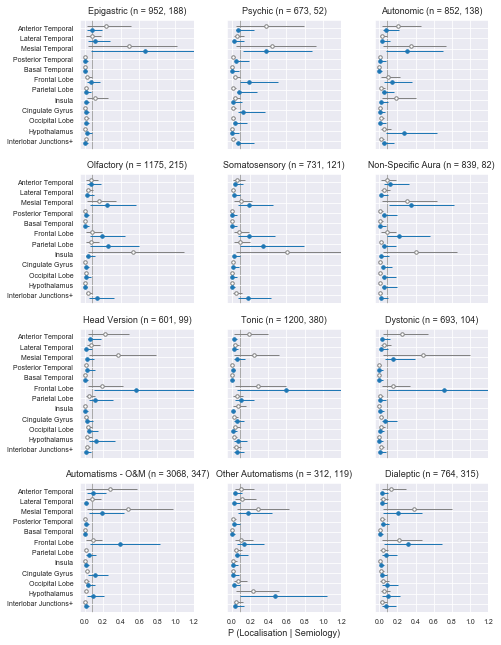

In [303]:
sns.set_style('darkgrid')
normalisation = 'temporal_normalised'
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = processed_dfs[normalisation]['full']['proportion'],
                               confint_df_1 = processed_dfs[normalisation]['full']['confints'],
                               counts_df_1 = processed_dfs['raw']['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = processed_dfs[normalisation]['spontaneous']['proportion'],
                               confint_df_2 = processed_dfs[normalisation]['spontaneous']['confints'],
                               counts_df_2 = processed_dfs['raw']['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(processed_dfs[normalisation]['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = labels.clean_semiologies(processed_dfs[normalisation]['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
                               figsize = (7, 9)
                              )

plt.savefig(F'scripts/figures/working_figures/fig-1/{normalisation}_not_bootstrapped.eps', dpi=300, pad_inches=0.5)

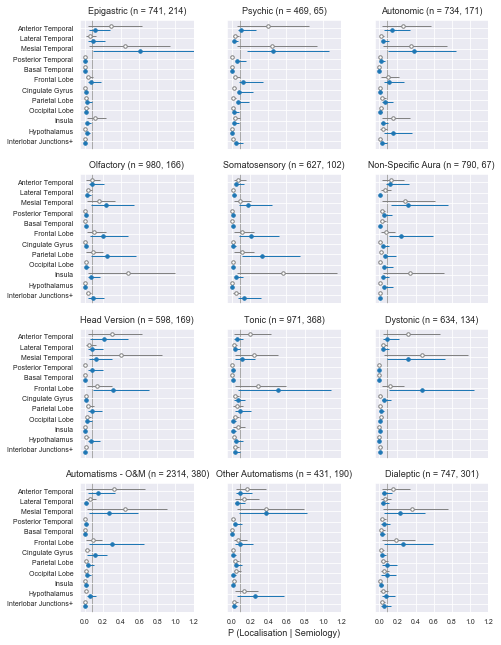

In [550]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
reload(interogate_queries)

results = {}
for study_type, query_result in query_results['raw'].items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        regions_of_interest = regions_of_interest,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    results[study_type] = result

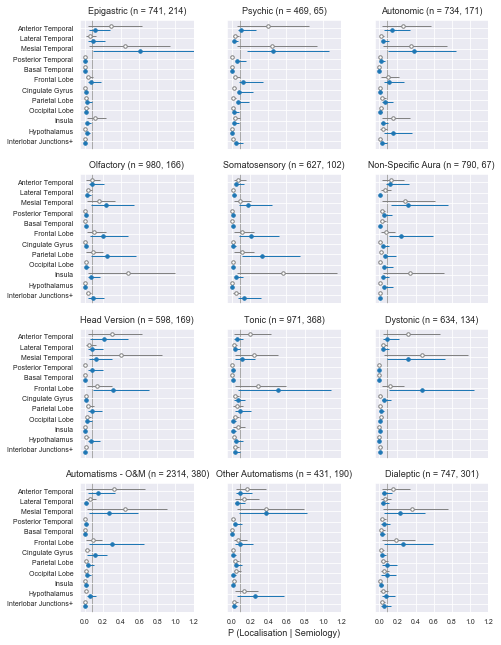

In [553]:
sns.set_style('darkgrid')
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
                               figsize = (7, 9)
                              )
plt.savefig(F'scripts/figures/working_figures/fig-1/{normalisation}_bootstrapped_new_normalisation.png', dpi=300, pad_inches=0.5)

_______
# Figure 2: By zone
________

In [118]:
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-20:]
axis = 'zone'

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(query_result,
                                                                      axis = axis,
                                                                      region_names = region_names,
                                                                      confint_method = 'binomial',
                                                                      merge_temporal = False,
                                                                      other_regions_included = True,
                                                                      semiologies_of_interest = semiologies_of_interest,
                                                                      regions_of_interest = regions_of_interest,
                                                                      drop_other_semiology = False)

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  denom = 1 + crit2 / nobs
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  center = (q_ + crit2 / (2 * nobs)) / denom
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


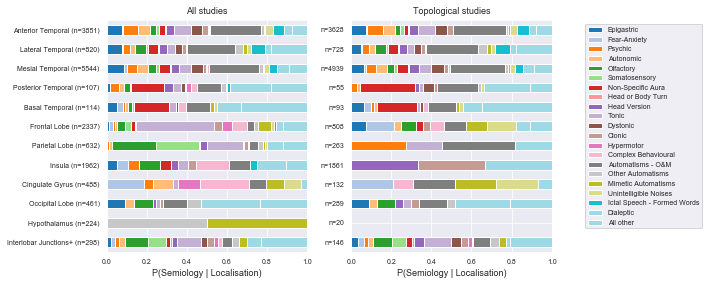

In [103]:
sns.set_style('darkgrid')
normalisation = 'temporal_normalised'

y_sums_1 = [int(n) for n in processed_dfs['raw']['full']['counts'].sum(0)]
y_sums_2 = [int(n) for n in processed_dfs['raw']['topology']['counts'].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(processed_dfs[normalisation]['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

color_palette =  sns.color_palette("tab20", as_cmap=True)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)

plotter.plot_stacked_hbar(processed_dfs[normalisation]['full']['proportion'], ax=axs[0],
                                      ax_title='All studies', axis=axis, color_palette=color_palette)
plotter.plot_stacked_hbar(processed_dfs[normalisation]['topology']['proportion'], ax=axs[1],
                                      ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs[normalisation]['topology']['proportion'].index))

axs[0].set_yticklabels(combine_labels_1[::-1])
axs[1].set_yticklabels(n_labels_2[::-1])

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures/fig-2/bar/{normalisation}.eps', dpi=300, pad_inches=0.5)

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


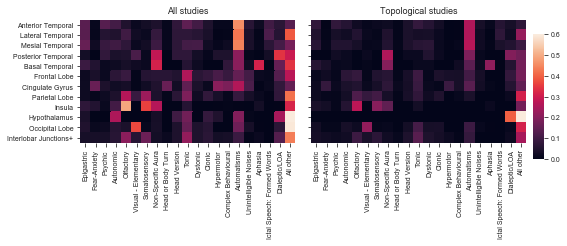

In [32]:
sns.set_style('ticks')
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.99, .3, .02, 0.576])
cbar_ax.patch.set_edgecolor('black')  
cbar_ax.patch.set_linewidth('1')  

heatmap_kwargs = {
    'square': True,
#      'xticklabels': x_labels
#     'vmin': 0.0,
#     'vmax': 1.0,
}

sns.heatmap(processed_dfs['normalised']['full']['proportion'].T, ax=axs[0], cbar=False, **heatmap_kwargs)
sns.heatmap(processed_dfs['normalised']['topology']['proportion'].T, ax=axs[1], cbar=True, cbar_ax = cbar_ax, **heatmap_kwargs)

axs[0].set_yticklabels(labels.clean_localisations(processed_dfs['normalised']['topology']['proportion'].columns), rotation=0)
axs[0].set_xticklabels(labels.clean_semiologies(processed_dfs['normalised']['topology']['proportion'].index))
axs[0].set_title('All studies')
axs[1].set_title('Topological studies')

# fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

# 2b - Region-specific subplots

- Q - use full, SS or topology?

In [33]:
def get_specific_df(query_results, columns_of_interest):
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [34]:
axis = 'zone'
normalised_or_not = 'normalised'

In [35]:
#Cingulate
cing_processed_dfs = {}
columns_of_interest = ['CING', 'Ant Cing (frontal, genu)', 'Post Cing', ]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['Cingulate - (anterior + posterior)'] = counts_df['CING'] - (counts_df['Post Cing'] + counts_df['Ant Cing (frontal, genu)'])
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    cing_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: invalid value encountered in sqrt
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [36]:
# SMA
sma_processed_dfs = {}
columns_of_interest = ['SSMA', 'SMA (pre-central gyrus; posterior SFG, MFG)', 'FL']
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['SMA'] = counts_df['SSMA'] + counts_df['SMA (pre-central gyrus; posterior SFG, MFG)']
    counts_df['FL-SMA'] = counts_df['FL'] - counts_df['SMA']
    counts_df = counts_df.drop(['SMA (pre-central gyrus; posterior SFG, MFG)', 'SSMA'], 1)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    sma_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

In [37]:
# PL
pl_processed_dfs = {}
columns_of_interest = ['PL',
                       'Primary Sensory Cortex (post-central gyrus)',
                       'medial anterior parietal',
                       'Sup. pariet. lobule',
                       'Inferior Parietal Lobule',]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    pl_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

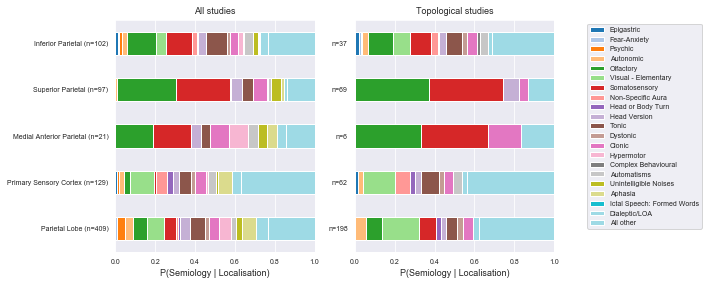

In [39]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 2.5))

#Choose from {cing_processed_dfs, pl_processed_dfs, sma_processed_dfs}
processed_dfs = copy.deepcopy(pl_processed_dfs)

y_labels = labels.clean_localisations(processed_dfs['full']['counts'].columns)
y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['topology']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['topology']['proportion'], ax=axs[1], ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[0].set_yticklabels(combine_labels_1)
axs[1].set_yticklabels(n_labels_2)
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs['topology']['proportion'].index))

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/PL.png', dpi=300, pad_inches=0.5)

---
# Figure 3: Odds ratio
---

Odds of semiology 1 localising to lobe A, divided by odds of NotSemiology A localising to lobe A. NotSemiology can be obtained by removing the result of QUERY_SEMIOLOGY from the original_df.
This gives Relative localising values. Interpret as intrinsic values of a specific semiology vs other semiologies. Narrow clinical history question.

In [318]:
def odds_ratio_df(counts, total_row):
    melted = counts.reset_index().melt(id_vars='index')
    melted = melted.rename(columns={'index': 'semiology', 'variable': 'localisation', 'value': 'a'})
    melted['localisation_total'] = np.zeros(len(melted))
    for localisation, total in total_row.to_dict().items():
        mask = melted['localisation'] == localisation
        melted.loc[mask, 'localisation_total'] = total
        
    melted['c'] = melted['localisation_total'] - melted['a']
    
    melted['semiology_total'] = np.zeros(len(melted))
    for semiology, total in counts.sum(1).to_dict().items():
        mask = melted['semiology'] == semiology
        melted.loc[mask, 'semiology_total'] = total
        
    melted['b'] = melted['semiology_total']-melted['a']
    
    melted['d'] = np.repeat(total_row.sum(), len(melted)) - (melted['a'] + melted['b'] + melted['c'])
    
    melted['OR'] = np.nan
    melted['OR_lower_ci'] = np.nan
    melted['OR_upper_ci'] = np.nan
    
    for i in melted.index:
        contingency_table = Table2x2(
        [[melted.loc[i, 'a'], melted.loc[i, 'b']],
         [melted.loc[i, 'c'], melted.loc[i, 'd']]] )

        melted.loc[i, 'OR'] = contingency_table.oddsratio
        melted.loc[i, 'OR_lower_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[0]
        melted.loc[i, 'OR_upper_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[1]
        
#         melted.loc[i, 'OR'] = contingency_table.log_oddsratio
#         melted.loc[i, 'OR_lower_ci'] = contingency_table.log_riskratio_confint(alpha = 0.05)[0]
#         melted.loc[i, 'OR_upper_ci'] = contingency_table.log_riskratio_confint(alpha = 0.05)[1]
    
    or_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR')
    or_l_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_lower_ci')
    or_u_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_upper_ci')
    
    or_dfs = {
        'counts': counts,
        'or': or_pivot,
        'confints': (or_l_pivot, or_u_pivot)
    }
    
    return or_dfs

In [334]:
axis='semiology'
regions_of_interest = region_names['low_level_temporal_of_interest']+region_names['of_interest_minus_tl']
semiologies_of_interest = sorted_semiologies[-12:]
processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

In [336]:
normalisation = 'temporal_normalised'
total_row = all_dfs[normalisation]['full'][regions_of_interest].sum()
total_row['All other'] = all_dfs[normalisation]['full'][region_names['top_level_all_other']].sum().sum()
odds_dfs = {}
odds_dfs['full'] = odds_ratio_df(processed_dfs[normalisation]['full']['counts'], total_row)
odds_dfs['spontaneous'] = odds_ratio_df(processed_dfs[normalisation]['spontaneous']['counts'], total_row)

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/contingency_tables.py:698: RuntimeWarning: invalid value encountered in log
  return np.dot(np.log(f), np.r_[1, -1, -1, 1])
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/contingency_tables.py:698: RuntimeWarning: invalid value encountered in log
  return np.dot(np.log(f), np.r_[1, -1, -1, 1])
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/contingency_tables.py:715: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(1 / self.table))


In [343]:
odds_dfs['full']['confints'][0]

localisation,Anterior (temporal pole),Basal (including Fusiform OTMG),CING,FL,Hypothalamus,INSULA,Lateral Temporal,Mesial Temporal,OL,PL,Posterior Temporal
semiology,,,,,,,,,,,
Automatisms - Oral & Manual,0.634909,0.110210,0.255615,0.035141,0.139679,0.004193,0.613321,0.591182,0.140914,0.073716,0.121986
Automatisms - Other,0.132388,0.011753,0.021126,0.044603,4.855507,0.030915,0.599924,0.236948,0.522355,0.260190,0.174737
Autonomic,0.449798,0.008857,0.057926,0.062410,0.899638,1.047418,0.186210,0.393815,0.141969,0.167941,0.058401
Dialeptic/LOA/LOC,0.254984,0.540425,0.250721,0.157493,0.898269,0.012515,0.228236,0.451688,0.420177,0.336294,1.294854
Dystonic,0.492671,0.011080,0.127826,0.094573,0.001386,0.000056,0.293029,0.554558,0.140987,0.071642,0.020383
Epigastric,0.569918,0.127637,0.035984,0.015781,0.069513,0.611541,0.574530,0.705485,0.119476,0.067432,0.015077
Head Version,0.415150,0.007816,0.079224,0.120292,0.348241,0.000139,0.388100,0.373587,0.232518,0.363355,0.214271
Non-Specific Aura,0.144965,0.846536,0.114738,0.048460,0.048627,3.676279,0.300514,0.338449,0.076081,0.111081,0.539366
Olfactory,0.115430,0.016900,0.048256,0.052920,0.000713,10.221698,0.270508,0.164435,0.069636,0.859817,0.022660


In [337]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'][order],
    confint_df_1 = [df[order] for df in odds_dfs['full']['confints']],
    counts_df_1 = processed_dfs['raw']['full']['counts'][order],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'][order],
    confint_df_2 = [df[order] for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = processed_dfs['raw']['spontaneous']['counts'][order],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'][order].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'][order].index),
    xlim = [-0.05,6],
    xticks = np.arange(0, 21, 2),
    vline = 1.0,
    xlabel = 'Odds ratio',
    plotter_settings = plotter_settings,
)

# plt.savefig('/Users/karan/Downloads/or_log_v1.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

KeyError: "['All other'] not in index"

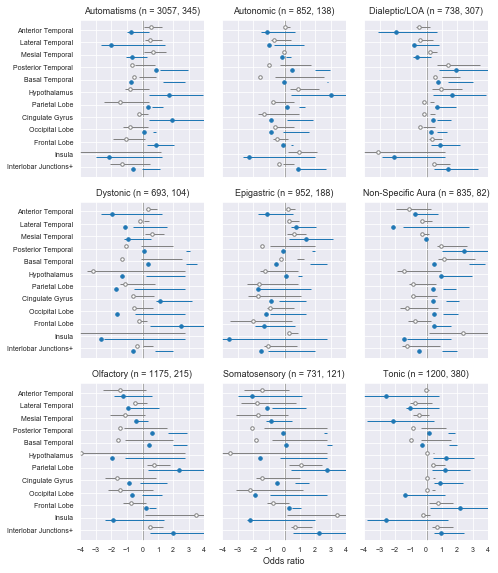

In [172]:
sns.set_style('darkgrid')
plotter_functions. plot_proportion_ci_forest_plot(
    proportion_df_1 = np.log(odds_dfs['full']['or'][order]),
    confint_df_1 = [np.log(df[order]) for df in odds_dfs['full']['confints']],
    counts_df_1 = processed_dfs['not_normalised']['full']['counts'][order],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = np.log(odds_dfs['spontaneous']['or'][order]),
    confint_df_2 = [np.log(df[order]) for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = processed_dfs['not_normalised']['spontaneous']['counts'][order],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'][order].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'][order].index),
    xlim = [-4,4],
    xticks = np.arange(-4, 5, 1),
#     vline = 1.0,
    xlabel = 'Odds ratio',
    plotter_settings = plotter_settings,
)
# 
# plt.savefig('/Users/karan/Downloads/or_log_v1.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

In [170]:
np.log(odds_dfs['full']['or'][order])

localisation,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),Hypothalamus,PL,CING,OL,FL,INSULA,All other
semiology,,,,,,,,,,,,
Automatisms Combination - Manual LowerLimb Oral,0.587881,0.532775,0.714003,-0.630543,-0.543647,-0.767051,-1.451725,-0.237882,-0.817000,-1.040490,-4.540588,-1.297179
Autonomous-Vegetative,0.083328,-0.650352,-0.000863,-0.998120,-1.559593,0.924738,-0.709829,-1.325805,-0.620691,-0.490350,0.953377,-0.362705
Dialeptic/LOA,-0.451875,-0.388612,0.271695,1.390914,0.576197,0.968796,-0.126367,-0.162379,-0.374832,0.405587,-3.093509,0.530584
Dystonic,0.376716,-0.158235,0.620148,-1.037617,-1.304587,-3.162354,-1.140737,-0.617592,-0.556502,-0.238027,-4.528223,-0.340481
Epigastric,0.241778,0.323356,0.625691,-1.446474,-0.235351,-1.236701,-1.634344,-1.702785,-0.887837,-1.979065,0.335885,-1.055262
Non-Specific Aura,-1.129495,-0.246686,-0.250315,0.946879,1.181929,-1.449742,-0.865949,-0.849482,-1.216641,-0.713726,2.380666,-1.227450
Olfactory,-1.411058,-0.449914,-1.127317,-1.401463,-1.562466,-3.941957,0.739674,-1.626389,-1.437337,-0.752344,3.496261,0.483480
Somatosensory,-1.455869,-1.777477,-1.678054,-2.051160,-1.799259,-3.472143,1.064181,-1.416906,-2.186254,-0.709584,3.414784,0.692001
Tonic,-0.016242,-0.710603,-0.486907,-0.829741,-0.964283,0.039332,0.439611,0.055200,0.081069,0.773789,-0.231200,0.670957


In [137]:
odds_dfs['full']['counts'].loc['Olfactory', 'INSULA']

507.3333333333333

In [330]:
order = ['Anterior (temporal pole)',
             'Lateral Temporal',
             'Mesial Temporal',
             'Posterior Temporal',
             'Basal (including Fusiform OTMG)',
             'Hypothalamus',
             'PL',
             'CING',
             'OL',
             'FL',
             'INSULA',
             'All other',
             ]

In [84]:
get_contingency_from_data(processed_dfs['normalised']['full']['counts'], 'Tonic', 'FL')

OR 3.65 95% CI 3.06 4.36
RR 2.9 95% CI 2.53 3.31
chi2 226.4 p 3.574069165869514e-51 dof 1


(array([[ 217.10519978,  545.62196581],
        [ 638.56146689, 5861.71136752]]),
 226.43349878713641,
 3.574069165869514e-51,
 1,
 array([[  89.85821442,  672.86895117],
        [ 765.80845224, 5734.46438216]]),
 3.6525830628227562,
 (3.059398063619848, 4.360780373585746))

In [89]:
processed_dfs['normalised']['full']['counts'].sum().sum()

7263.0

In [90]:
total_row.sum()

9006.911111111109

In [87]:
odds_dfs['full']['or'].loc[ 'Tonic', 'FL']

# odds_dfs['full']['confints'][0].loc[ 'Tonic', 'FL']

# odds_dfs['full']['counts'].loc[ 'Tonic', 'Posterior Temporal']

2.1679649187838392

In [545]:
reload(plotter_functions)

<module 'scripts.figures.plotter_functions' from '/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/plotter_functions.py'>

## Compare normalisation

In [109]:
processed_dfs['normalised']['full']['counts']

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,CING,PL,INSULA,Hypothalamus,OL,All other
Epigastric,162.333333,53.413596,333.336404,1.000000,2.500000,16.916667,3.333333,5.083333,77.166667,5.000000,9.750000,6.0
Autonomous-Vegetative,125.871429,19.500000,207.147619,1.333333,0.600000,57.238095,4.142857,10.666667,107.666667,31.000000,10.833333,10.0
Olfactory,60.333333,38.473077,154.610256,1.500000,1.000000,75.166667,5.166667,60.833333,507.333333,0.000000,8.250000,34.0
Somatosensory,36.500000,7.000000,61.500000,0.500000,0.500000,49.833333,4.000000,53.000000,374.333333,0.000000,2.500000,27.0
Non-Specific Aura,53.166667,32.133333,201.366667,9.000000,8.500000,53.750000,7.500000,10.500000,273.750000,4.000000,7.000000,5.0
Tonic,170.800000,27.347222,222.308333,2.333333,1.600000,217.105200,22.339245,43.666667,61.000000,21.000000,30.166667,36.0
Dystonic,122.300000,24.000000,228.600000,1.000000,0.600000,55.595238,6.404762,5.500000,0.000000,0.000000,9.000000,8.0
Automatisms Combination - Manual LowerLimb Oral,540.702381,165.574477,930.116000,6.666667,5.607143,127.321905,39.344762,19.333333,2.500000,24.000000,32.000000,15.0
Dialeptic/LOA,77.516667,23.153221,226.487255,10.830769,4.266667,109.800061,11.720085,17.148352,2.500000,30.183333,12.726923,21.0


In [110]:
processed_dfs['not_normalised']['full']['counts']

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,CING,PL,INSULA,Hypothalamus,OL,All other
Epigastric,293.0,53.0,447.0,1.0,4.0,29.0,5.0,12.0,84.0,5.0,13.0,6.0
Autonomous-Vegetative,236.0,21.0,313.0,3.0,1.0,75.0,7.0,23.0,121.0,30.0,12.0,10.0
Olfactory,107.0,49.0,213.0,2.0,2.0,118.0,9.0,99.0,528.0,0.0,14.0,34.0
Somatosensory,65.0,7.0,90.0,1.0,1.0,73.0,7.0,75.0,381.0,0.0,4.0,27.0
Non-Specific Aura,108.0,51.0,245.0,24.0,27.0,62.0,11.0,13.0,276.0,4.0,9.0,5.0
Tonic,281.0,31.0,334.0,4.0,3.0,293.0,37.0,57.0,67.0,21.0,36.0,36.0
Dystonic,223.0,26.0,330.0,1.0,1.0,77.0,8.0,8.0,1.0,0.0,10.0,8.0
Automatisms Combination - Manual LowerLimb Oral,1024.0,182.0,1418.0,13.0,14.0,215.0,70.0,32.0,11.0,24.0,39.0,15.0
Dialeptic/LOA,111.0,43.0,259.0,24.0,16.0,145.0,14.0,33.0,4.0,32.0,36.0,21.0


# NMI/Correlation

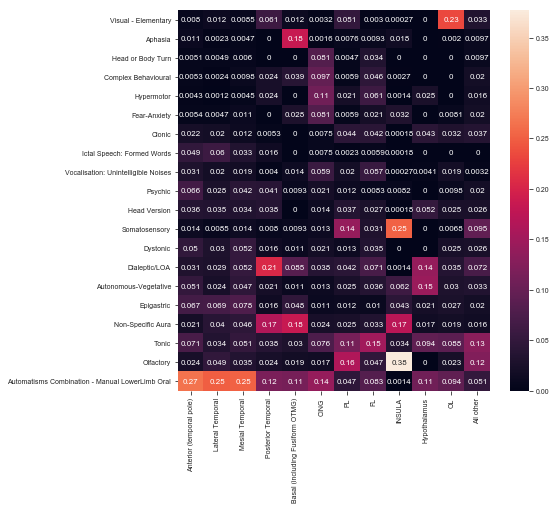

In [836]:
# sns.set_style('ticks')
# fig, axs = plt.subplots(1, 1, figsize=(7.5, 8), sharey=True, sharex=True)
# cbar_ax = fig.add_axes([0.99, .3, .02, 0.576])
# cbar_ax.patch.set_edgecolor('black')  
# cbar_ax.patch.set_linewidth('1')  

# heatmap_kwargs = {
#     'square': True,
# }
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(7, 7))
sns.heatmap(odds.loc[semiologies_of_interest], cbar=True, annot=True)

# axs.set_yticklabels(region_names['roi_clean_labels'], rotation=0)
# axs.set_title('All studies')

# # fig.colorbar(im, orientation="horizontal", pad=0.2)

# plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

In [775]:
import dython

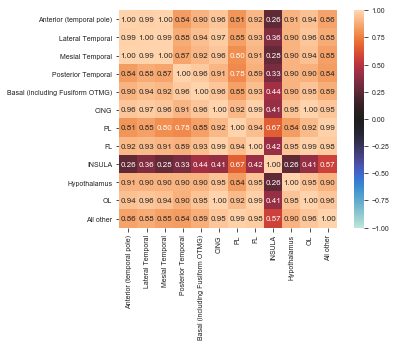

{'corr':                                  Anterior (temporal pole)  Lateral Temporal  \
 Anterior (temporal pole)                         1.000000          0.990158   
 Lateral Temporal                                 0.990158          1.000000   
 Mesial Temporal                                  0.995901          0.994472   
 Posterior Temporal                               0.840019          0.875255   
 Basal (including Fusiform OTMG)                  0.900717          0.935554   
 CING                                             0.958614          0.970846   
 PL                                               0.814266          0.848953   
 FL                                               0.917838          0.926684   
 INSULA                                           0.262681          0.355559   
 Hypothalamus                                     0.905641          0.902420   
 OL                                               0.943314          0.956764   
 All other                      

In [777]:
dython.nominal.associations(counts, theil_u=True)

----
## Junk
----